In [1]:
print('kernel live')

kernel live


In [47]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy import stats
import seaborn as sns
import altair as alt

alt.data_transformers.disable_max_rows();

# load data

In [4]:
by = 'by_text' # by_text or as_single_text or by_source
gap = 24; gap=str(gap) # 0 or 24. units are hours
sim_type = 'BC' # BC or cosine or SWF
resampling = '_r1' # ''
control = ''#'_control'

all_parties = pd.read_parquet('./data/results_'+by+'__'+gap+'hr_'+sim_type+resampling+control+'.parquet')
con = pd.read_parquet('./data/results_'+by+'_Con_'+gap+'hr_'+sim_type+resampling+control+'.parquet')
lab = pd.read_parquet('./data/results_'+by+'_Lab_'+gap+'hr_'+sim_type+resampling+control+'.parquet')

con['responding_party'] = 'Con'
lab['responding_party'] = 'Lab'
all_parties['responding_party'] = 'All'

df = pd.concat([con, lab, all_parties])

In [5]:
text_types = list(df['text_type'].unique())

# config

In [6]:
# official colors from 
# https://en.wikipedia.org/wiki/Wikipedia:Index_of_United_Kingdom_political_parties_meta_attributes

parties = ['All','Lab','Con'] #order determines draw order in plots

party_colors = {'All':'#000000',
                'Con':'#0087DC', 
                'Lab':'#E4003B',
                'SNP':'#FDF38E', #Scottish National Party 
                'Lab/Co-op':'#E4003B',
                'LD':'#FAA61A', #Liberal Democrats
                'Ind':'#DDDDDD',
                'DUP':'#D46A4C', # Democratic Unionist Party 
                'PC':'#005B54', #Plaid Cymru
                'Green':'#6AB023'} 
quantile_range_to_plot = (0.025, 0.975)
n_boot = 200

# lineplot helper funcs

In [22]:
correlates_of_cause = {
                       'tweet':['n_likes','n_replies','n_retweets','n_quotes'],
                       'url':['sum_views','sum_clicks','sum_shares','sum_likes',
                              'sum_loves','sum_hahas','sum_wows','sum_sorrys',
                              'sum_angers','sum_comments','sum_share_without_clicks',
#                               'newsguard_score'
                             ],
#                        'commons_speech':['mp_name','constituency','party','job'],
                      }

def get_residuals(df, correlate, cause_type, response_type):
    response_col = response_type+'_sim_delta'
    y = np.array(df[response_col])
    X_others = np.array(df[[x for x in correlates_of_cause[cause_type] if x!=correlate]])
    y_mean = np.mean(y)
    y_hat_others = LinearRegression().fit(X_others, y).predict(X_others)
    residual = y - y_hat_others# + y_mean
    return residual

def plot_correlate_log_bins(df, correlate, response_type, cause_type, ax, swap_x_y=False, make_ylabel=False,
                            residual = False):
    
    #set up labels
    xlabel = correlate.replace('_',' ').replace('sum ','').title()
    ylabel = 'Change in\n' + response_type.replace('_',' ').replace('sum ','').title().split(' ')[0] + ' Content'
    response_type
    response_col = response_type+'_sim_delta'
    if swap_x_y:
        xlabel, ylabel = ylabel, xlabel
        response_col, correlate = correlate, response_col
    
    #filter by cause type
    df = df[df['text_type']==cause_type].copy()
    
    #bin by correlate
    n_bins = 16
    logx = not swap_x_y and correlate!='newsguard_score'
    lower = df[correlate].quantile(quantile_range_to_plot[0])
    lower = max(lower,1) if logx else lower
    upper = df[correlate].quantile(quantile_range_to_plot[1])
        
    if logx:
        bins = np.logspace(np.log10(lower), np.log10(upper), n_bins)
#         df[correlate] = pd.cut(df[correlate], 
#                                bins = bins)
                              
#         df[correlate] = df[correlate].apply(lambda x: (x.left * x.right)**(1/2)) #geometric mean of bin boundaries
    else:
        bins = np.linspace(lower, upper, n_bins)
#         df[correlate] = pd.cut(df[correlate], bins = bins)
#         df[correlate] = df[correlate].apply(lambda x: (x.left + x.right)*(1/2)) #arithmetic mean of bin boundaries
    
    df[df[correlate]<lower] = np.nan
    df[df[correlate]>upper] = np.nan
    #plot bin means of response
    for party in parties:
        plot_data = df[df['responding_party']==party]
        plot_data = plot_data[[response_col]+correlates_of_cause[cause_type]].dropna()
        if residual: plot_data[response_col+'_residual'] = get_residuals(plot_data, correlate, cause_type, response_type)
        y_col = response_col+'_residual' if residual else response_col
        ax = sns.regplot(data = plot_data, 
                           x = correlate, y = y_col,
                           color=party_colors[party], x_ci=95, ci=None, ax=ax, x_bins = bins,
                           logx = logx, n_boot = n_boot)
    if logx: 
        ax.set_xscale('log')
    
    ax.set_xlabel(xlabel)
#     ax.set_xlim(left = bins[0], right=bins[-1])
    if make_ylabel: ax.set_ylabel(ylabel)
    else: ax.set_ylabel('')
    
    return ax

In [23]:
#TODO

def adjust_font_sizes(axes, tick_size = 12, label_size = 14):#, xlabel_size, ylabel_size, xtick_size, ytick_size):
    original_shape = axes.shape
    axes = axes.reshape(-1)
    for i, ax in enumerate(axes):
        _ = [tick.set_fontsize(tick_size) for tick in ax.get_xticklabels()]
        _ = [tick.set_fontsize(tick_size) for tick in ax.get_yticklabels()]
        ax.xaxis.label.set_fontsize(label_size)
        ax.yaxis.label.set_fontsize(label_size)
    axes = axes.reshape(original_shape)
    return axes

# Plot 1: Influence of URLs on Commons

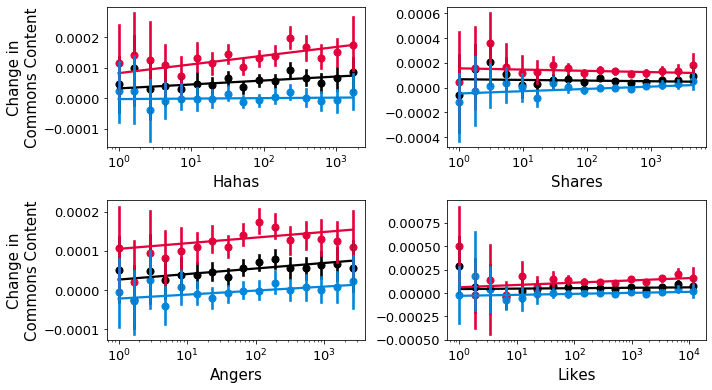

In [24]:
cause_type = 'url'
response_type = 'commons_speech'
correlates = ['sum_hahas','sum_shares','sum_angers','sum_likes']
# correlates = ['sum_hahas', 'sum_views']

size = int(np.ceil(np.sqrt(len(correlates))))
fig, axes = plt.subplots(size, size)
for i in range(size): 
    for j, correlate in enumerate(correlates[i*size:(i+1)*size]): 
        plot_correlate_log_bins(df, correlate, response_type, cause_type, axes[i,j], False, (j==0))


axes = adjust_font_sizes(axes, 13, 15)
# axes[0].legend(labels = parties, loc = 'upper left')
fig.set_size_inches(5*size, 3*size)
# fig.suptitle('Influence of URLs on Commons Speeches', fontsize = 15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect accounts for suptitle
fig.show()

# Plot 2: Influence of URLs on MP Tweets

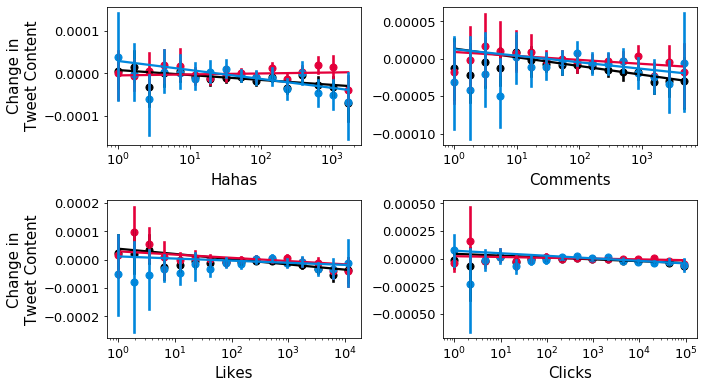

In [68]:
cause_type = 'url'
response_type = 'tweet'
correlates = ['sum_hahas', 'sum_comments','sum_likes','sum_clicks']#, 'newsguard_score']

size = int(np.ceil(np.sqrt(len(correlates))))
fig, axes = plt.subplots(size, size)
for i in range(size): 
    for j, correlate in enumerate(correlates[i*size:(i+1)*size]): 
        plot_correlate_log_bins(df, correlate, response_type, cause_type, axes[i,j], False, (j==0))
        
axes = adjust_font_sizes(axes, 13, 15)
# axes[0,0].legend(labels = parties, loc = 'upper left')
fig.set_size_inches(5*size, 3*size)
# fig.suptitle('Influence of URLs on MP Tweets', fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect accounts for suptitle
fig.show()

# Plot 3: Influence of MP Tweets on Commons

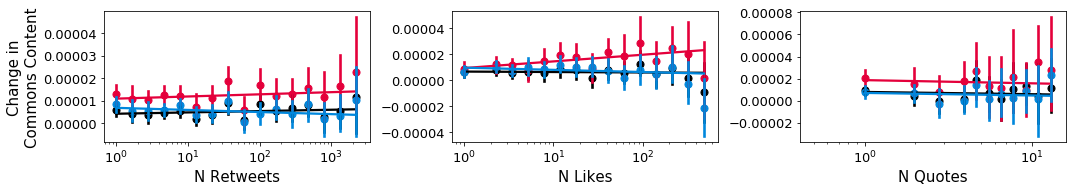

In [26]:
cause_type = 'tweet'
response_type = 'commons_speech'
correlates = ['n_retweets','n_likes', 'n_quotes']

fig, axes = plt.subplots(1, len(correlates))
for i, correlate in enumerate(correlates): 
    plot_correlate_log_bins(df, correlate, response_type, cause_type, axes[i], False, (i==0))
#     axes[i].set_xlim(left=1)

    
axes = adjust_font_sizes(axes, 13, 15)
# axes[0,0].legend(labels = parties, loc = 'upper left')
fig.set_size_inches(len(correlates)*5, 3)
# fig.suptitle('Influence of MP Tweets on Commons Speeches', fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect accounts for suptitle
fig.show()

# Plot 4: Influence of MP tweet on MP tweet

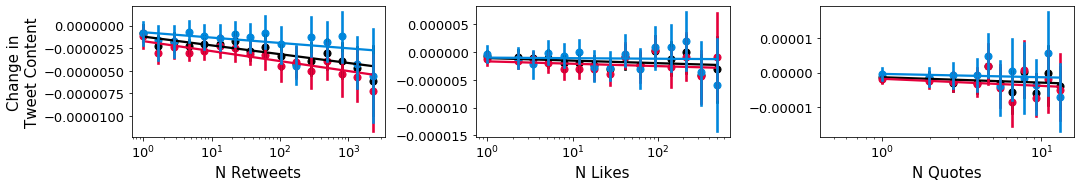

In [27]:
cause_type = 'tweet'
response_type = 'tweet'
correlates = ['n_retweets','n_likes', 'n_quotes']

fig, axes = plt.subplots(1, len(correlates))
for i, correlate in enumerate(correlates): 
    plot_correlate_log_bins(df, correlate, response_type, cause_type, axes[i], False, (i==0))
#     axes[i].set_xlim(left=1)

axes = adjust_font_sizes(axes, 13, 15)
# axes[0,0].legend(labels = parties, loc = 'upper left')
fig.set_size_inches(len(correlates)*5, 3)
# fig.suptitle('Influence of MP Tweets on MP Tweets', fontsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]) #rect accounts for suptitle
fig.show()

# summary stats plots

In [29]:
texts = pd.read_parquet('./data/all_texts_cleaned.parquet')
texts['party'] = texts['party'].apply(lambda x: 'Lab' if x=='Lab/Co-op' else x)

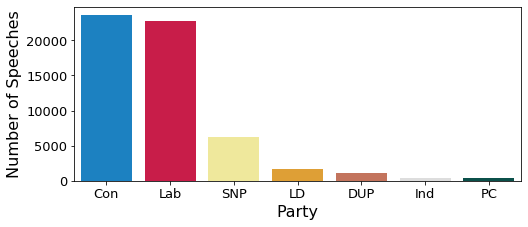

In [36]:
plot_data = texts[texts['text_type']=='commons_speech']
plot_data = pd.DataFrame(plot_data['party'].value_counts()
                        ).reset_index(
                        ).rename(columns = {'index':'Party','party':'Number of Speeches'}
                        )
plot_data = plot_data[:7]

f, ax = plt.subplots(figsize=(8, 3.2))
sns.barplot(x="Party", y="Number of Speeches", data=plot_data,
              palette=party_colors)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
for tick in ax.get_xticklabels()+ax.get_yticklabels():
    tick.set_fontsize(13)


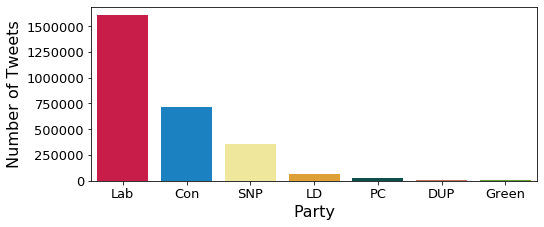

In [40]:
plot_data = texts[texts['text_type']=='tweet']
plot_data = pd.DataFrame(plot_data['party'].value_counts()
                        ).reset_index(
                        ).rename(columns = {'index':'Party','party':'Number of Tweets'}
                        )
plot_data = plot_data[:7]

f, ax = plt.subplots(figsize=(8, 3.2))
sns.set_color_codes("pastel")
sns.barplot(x="Party", y="Number of Tweets", data=plot_data,
            palette=party_colors)
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
for tick in ax.get_xticklabels()+ax.get_yticklabels():
    tick.set_fontsize(13)


In [66]:
domain_affilitations = {
 'www.theguardian.com':'Left',
 'www.dailymail.co.uk':'Right',
 'www.independent.co.uk':'Left',
 'www.mirror.co.uk':'Left',
 'www.bbc.com':'Center',
 'www.thesun.co.uk':'Right',
 'www.bbc.co.uk':'Center',
 'www.express.co.uk':'Right',
 'metro.co.uk':'Left',
 'www.telegraph.co.uk':'Right',
 'www.belfasttelegraph.co.uk':'Unknown',
 'www.lancashiretelegraph.co.uk':'Unknown',
 'www.bbc.co.uk | www.bbc.com':'Center',

}

affil_colors = {
    'Left':'#E4003B', #Lab party color
    'Right':'#0087DC', #Con party color
    'Center':'#808080', #black
    'Unknown':'#000000' #grey
}

domain_colors = {k:affil_colors[domain_affilitations[k]] for k in domain_affilitations.keys()}
domain_colors

{'www.theguardian.com': '#E4003B',
 'www.dailymail.co.uk': '#0087DC',
 'www.independent.co.uk': '#E4003B',
 'www.mirror.co.uk': '#E4003B',
 'www.bbc.com': '#808080',
 'www.thesun.co.uk': '#0087DC',
 'www.bbc.co.uk': '#808080',
 'www.express.co.uk': '#0087DC',
 'metro.co.uk': '#E4003B',
 'www.telegraph.co.uk': '#0087DC',
 'www.belfasttelegraph.co.uk': '#000000',
 'www.lancashiretelegraph.co.uk': '#000000',
 'www.bbc.co.uk | www.bbc.com': '#808080'}

<ipython-input-69-59b6cbc99c19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['domain'] = plot_data['domain'].apply(lambda x: 'www.bbc.co.uk | www.bbc.com'


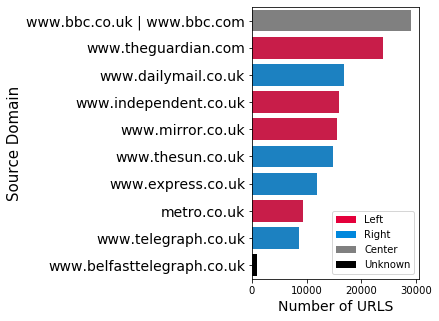

In [69]:
plot_data = texts[texts['text_type']=='url']
plot_data['domain'] = plot_data['domain'].apply(lambda x: 'www.bbc.co.uk | www.bbc.com' 
                                                if (x=='www.bbc.co.uk' or x=='www.bbc.com') 
                                                else x)
plot_data = pd.DataFrame(plot_data['domain'].value_counts()
                        ).reset_index(
                        ).rename(columns = {'index':'Source Domain','domain':'Number of URLS'}, 
                        )
plot_data = plot_data[:10]

f, ax = plt.subplots(figsize=(3,5))
sns.set_color_codes("pastel")
sns.barplot(x="Number of URLS", y="Source Domain", data=plot_data,
            label="Number of URLs", palette=domain_colors)
ax.xaxis.label.set_fontsize(14)
ax.yaxis.label.set_fontsize(15)
for tick in ax.get_xticklabels(): tick.set_fontsize(10)
for tick in ax.get_yticklabels(): tick.set_fontsize(14)
    
ax.legend([Patch(facecolor = affil_colors[k]) for k in affil_colors.keys()],
          [k for k in affil_colors.keys()])

plt.show()